In [1]:
%pip install pandas statsmodels matplotlib

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
# Calculating forecast accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna

In [3]:
# Load your data
# Assuming you have a CSV file with columns: 'date', 'dengue_patient_count', 'precipitation', 'wind_speed', 'temperature'
original_df = pd.read_csv('Colombo_df.csv', parse_dates=['Date'], index_col='Date')

In [4]:
if "Predicted" in original_df.columns:
    original_df.drop(['Predicted'],axis=1,inplace=True)

#### Data Transformation

In [5]:
df = original_df.sort_values('Date').copy()
df.shape

(210, 10)

In [6]:
# Check the first few rows of the dataframe
df.drop(columns=['station_name','Year','Month'], inplace=True)

# Combine 'TMPMAX' and 'TMPMIN' into 'TMPAVG'
df['TMPAVG'] = df[['TMPMAX', 'TMPMIN']].mean(axis=1)

# Combine 'wind_speed_8_30am' and 'wind_speed_17_30pm' into 'wind_speed_avg'
df['wind_speed_avg'] = df[['wind_speed_8_30am', 'wind_speed_17_30pm']].mean(axis=1)

# Drop the original columns if no longer needed
df = df.drop(columns=['TMPMAX', 'TMPMIN', 'wind_speed_8_30am', 'wind_speed_17_30pm'])

In [7]:
print(f"shape = {df.shape}\n")
print(df.head())
print(df.describe())

shape = (210, 5)

             humidity  precipitation  patients  TMPAVG  wind_speed_avg
Date                                                                  
2007-01-01  82.258065      91.100001       244   27.35            5.85
2007-02-01  84.142857       9.900000       175   27.35            4.85
2007-03-01  85.806452      60.500001        61   28.30            4.35
2007-04-01  91.433333     374.100007        35   28.25            3.45
2007-05-01  84.709677     432.400013        44   28.90            5.30
         humidity  precipitation     patients      TMPAVG  wind_speed_avg
count  210.000000     210.000000   210.000000  210.000000      210.000000
mean    82.053844     207.720953   748.023810   28.090000        5.117238
std      4.199268     164.237256   893.786453    0.695705        1.198141
min     71.200000       0.100000    24.000000   26.550000        1.350000
25%     79.425000      91.549998   273.750000   27.550000        4.300000
50%     82.050000     156.999999   551.50

### Spliting of Datasets

In [8]:
# Splitting the data into training and testing sets
train_data = df[:'2020']      # train model with data till 2020
test_data = df['2021':].copy()   # test dataset 2021-2023

print(train_data.tail(5))
print(test_data.head(5))
print(test_data.tail(5))

            humidity  precipitation  patients  TMPAVG  wind_speed_avg
Date                                                                 
2020-08-01     80.25      97.500000       279   28.50            4.15
2020-09-01     84.50     517.700002       225   27.60            3.95
2020-10-01     81.30     125.600000       153   28.40            4.15
2020-11-01     81.95     143.600000        79   28.15            3.75
2020-12-01     80.10     321.899995        74   27.65            5.95
            humidity  precipitation  patients  TMPAVG  wind_speed_avg
Date                                                                 
2021-01-01     81.20     267.700000        24   28.40            4.00
2021-02-01     74.10      45.899999       115   28.05            6.00
2021-03-01     80.65     148.600000        67   28.00            2.45
2021-04-01     80.30     325.600002       318   28.70            3.00
2021-05-01     81.65     351.400001       336   28.70            3.35
            humidity

### Model Training with Optomized HyperParameters 
##### Best parameters: {'p': 0, 'd': 0, 'q': 6, 'P': 5, 'D': 1, 'Q': 2}

In [9]:
# Defining the SARIMAX model
tuned_model = sm.tsa.SARIMAX(train_data['patients'],
        exog=train_data[['humidity','precipitation','TMPAVG','wind_speed_avg']],
        order=(5, 0, 1),
                       seasonal_order=(1, 0, 0, 12),  # s =12
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fitting the model    
final_model_fit = tuned_model.fit(disp=False)

C:\Users\dell\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\dell\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\dell\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [10]:
# Making predictions for test dataset
testdata_forecast = final_model_fit.get_forecast(steps=len(test_data), exog=test_data.drop(['patients'],axis=1))
final_forecast_ci = testdata_forecast.conf_int()

In [11]:
test_data.loc[:, 'Predicted'] = testdata_forecast.predicted_mean
test_data['Predicted'] = test_data['Predicted'].clip(lower=0)

#### Visulization

In [12]:
# Ensure the test dataset only contains data up to 2023
test_data_2023 = test_data[test_data.index <= '2023-12-31']
test_data_2024 = test_data[test_data.index > '2023-12-31']

In [13]:
test_data_2023.tail()

,humidity,precipitation,patients,TMPAVG,wind_speed_avg,Predicted
Date,,,,,,
2023-08-01,78.35,82.299999,881,29.30,5.25,853.077000
2023-09-01,86.30,722.200008,750,27.55,3.85,693.841848
2023-10-01,87.05,636.599997,423,27.45,1.60,415.867909
2023-11-01,85.55,421.699999,380,27.95,1.35,363.391517
2023-12-01,83.95,337.500002,602,28.25,3.70,591.477945


RMSE for test dataset : 93.88313762186564
RMSE for 2024 dataset : 413.6910214815457


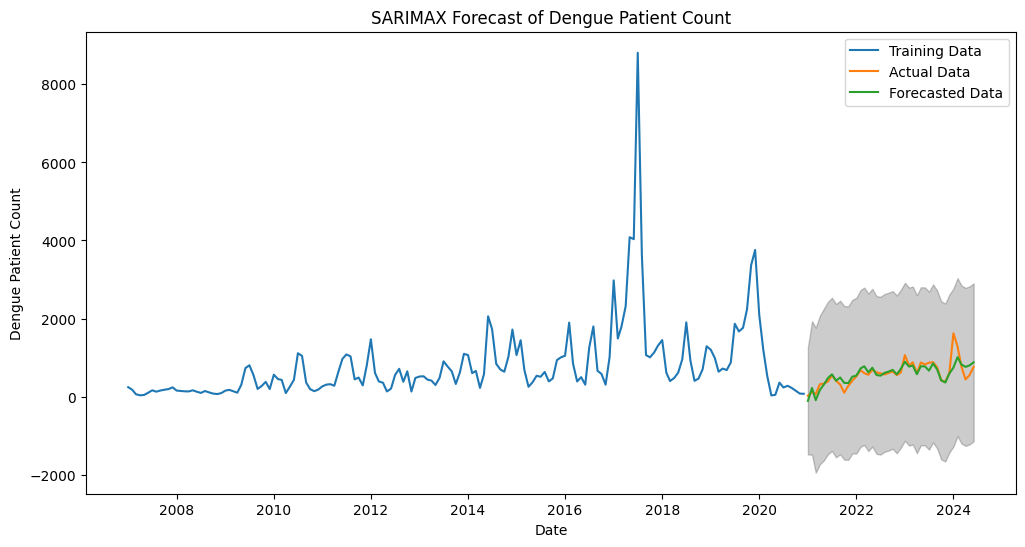

In [14]:
test_mse = mean_squared_error(test_data_2023['patients'], test_data_2023['Predicted'])
final_rmse = np.sqrt(test_mse)
print(f"RMSE for test dataset : {final_rmse}")

test_mse = mean_squared_error(test_data_2024['patients'], test_data_2024['Predicted'])
_rmse = np.sqrt(test_mse)
print(f"RMSE for 2024 dataset : {_rmse}")

# Plotting the results
plt.figure(figsize=(12, 6))

# plot the actual train dataset
plt.plot(train_data.index, train_data['patients'], label='Training Data')

# plot the test dataset and predictions
plt.plot(test_data.index, test_data['patients'], label='Actual Data')
plt.plot(test_data.index, testdata_forecast.predicted_mean, label='Forecasted Data')
plt.fill_between(test_data.index, final_forecast_ci.iloc[:, 0], final_forecast_ci.iloc[:, 1], color='k', alpha=0.2)


plt.xlabel('Date')
plt.ylabel('Dengue Patient Count')
plt.title('SARIMAX Forecast of Dengue Patient Count')
plt.legend()
plt.show()

In [15]:
# Merge the predictions back into the original DataFrame
original_df['Predicted'] = test_data['Predicted']

# Save the updated dataframe to CSV
original_df.to_csv('Colombo_df.csv')